In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import warnings
import joblib
import lime
import lime.lime_tabular
import pickle
import json
from joblib import Parallel, delayed
import os
from datetime import datetime
from IPython.display import HTML, display
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model as keras_load_model

# ================= Train DNN Imports =================
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical



# Suppress specific warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', module='xgboost')
warnings.filterwarnings('ignore', module='lightgbm')
warnings.filterwarnings('ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings

# Create models directory if it doesn't exist
models_dir = "models"
os.makedirs(models_dir, exist_ok=True)

In [27]:
import sys
print(sys.executable)

c:\Users\luffy\Desktop\XAINIDS\.venv\Scripts\python.exe


In [28]:
np.__version__

'2.0.0'

In [29]:
DOCS_DIR = './docs'  
MODEL_DIR = './models'
sample_file = f'{DOCS_DIR}/preprocessed_data.csv'

In [63]:
def load_model(model_name, models_dir="./models"):
    """
    Load the saved scaler, model (including DNN .h5), and label encoder by name.

    Parameters:
    model_name (str): Name of the model (e.g., 'Random Forest', 'DNN')
    models_dir (str): Directory where models are saved

    Returns:
    tuple: (scaler, model, label_encoder)
    """
    # Determine model path
    if model_name == "DNN" or model_name == "dnn":
        model_path = os.path.join(models_dir, "dnn.h5")
    else:
        model_filename = f"{model_name.replace(' ', '_').lower()}.pkl"
        model_path = os.path.join(models_dir, model_filename)

    scaler_path = os.path.join(models_dir, "scaler.pkl")
    label_encoder_path = os.path.join(models_dir, "label_encoder.pkl")

    # Check file existence
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"❌ Model file not found: {model_path}")
    if not os.path.exists(scaler_path):
        raise FileNotFoundError(f"❌ Scaler file not found: {scaler_path}")
    if not os.path.exists(label_encoder_path):
        raise FileNotFoundError(f"❌ LabelEncoder file not found: {label_encoder_path}")

    # Load all artifacts
    scaler = joblib.load(scaler_path)
    if model_name == "DNN" or model_name == 'dnn':
        model = keras_load_model(model_path)
    else:
        model = joblib.load(model_path)

    with open(label_encoder_path, "rb") as f:
        le = pickle.load(f)

    return scaler, model, le

# 💡 Usage example
print("\n💡 To load a saved model, scaler, and label encoder, use:")
print("   scaler, model, le = load_model('Random Forest')")


💡 To load a saved model, scaler, and label encoder, use:
   scaler, model, le = load_model('Random Forest')


In [31]:
df = pd.read_csv(sample_file)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565423 entries, 0 to 565422
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   total_length_of_fwd_packets  565423 non-null  float64
 1   total_length_of_bwd_packets  565423 non-null  float64
 2   fwd_packet_length_max        565423 non-null  float64
 3   bwd_packet_length_max        565423 non-null  float64
 4   bwd_packet_length_mean       565423 non-null  float64
 5   max_packet_length            565423 non-null  float64
 6   packet_length_mean           565423 non-null  float64
 7   packet_length_std            565423 non-null  float64
 8   packet_length_variance       565423 non-null  float64
 9   average_packet_size          565423 non-null  float64
 10  avg_bwd_segment_size         565423 non-null  float64
 11  subflow_fwd_bytes            565423 non-null  float64
 12  subflow_bwd_bytes            565423 non-null  float64
 13 

In [33]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [34]:
x

,total_length_of_fwd_packets,total_length_of_bwd_packets,fwd_packet_length_max,bwd_packet_length_max,bwd_packet_length_mean,max_packet_length,packet_length_mean,packet_length_std,packet_length_variance,average_packet_size,avg_bwd_segment_size,subflow_fwd_bytes,subflow_bwd_bytes,init_win_bytes_forward,init_win_bytes_backward
0,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,264.0,-1.0
1,62.0,208.0,31.0,104.0,104.0000,104.0,60.200000,39.983747,1598.700000,75.250000,104.0000,62.0,208.0,-1.0,-1.0
2,12.0,0.0,6.0,0.0,0.0000,6.0,6.000000,0.000000,0.000000,9.000000,0.0000,12.0,0.0,258.0,-1.0
3,80.0,112.0,40.0,56.0,56.0000,56.0,46.400000,8.763561,76.800000,58.000000,56.0000,80.0,112.0,-1.0,-1.0
4,57.0,173.0,57.0,173.0,173.0000,173.0,95.666667,66.972631,4485.333333,143.500000,173.0000,57.0,173.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565418,0.0,0.0,0.0,0.0,0.0000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,243.0,290.0
565419,43.0,171.0,43.0,171.0,171.0000,171.0,85.666667,73.900834,5461.333333,128.500000,171.0000,43.0,171.0,-1.0,-1.0
565420,1176.0,5339.0,693.0,1448.0,667.3750,1448.0,296.136364,506.385257,256426.028139,310.238095,667.3750,1176.0,5339.0,65535.0,246.0
565421,5823.0,7281.0,2912.0,1448.0,455.0625,2912.0,468.000000,859.325101,738439.629600,485.333333,455.0625,5823.0,7281.0,29200.0,75.0


In [35]:
y

0         0
1         0
2         0
3         0
4         0
         ..
565418    0
565419    0
565420    0
565421    0
565422    0
Name: label, Length: 565423, dtype: int64

In [36]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(x) 

# Save the scaler
joblib.dump(scaler, f"{MODEL_DIR}/scaler.pkl")
print("Scaler saved to models/scaler.pkl")


Scaler saved to models/scaler.pkl


In [37]:
X_scaled

array([[-0.07876342, -0.00722908, -0.28899089, ..., -0.00722949,
        -0.4684919 , -0.23464292],
       [-0.06988111, -0.00714797, -0.24586022, ..., -0.00714837,
        -0.48702575, -0.23464292],
       [-0.07704426, -0.00722908, -0.28064302, ..., -0.00722949,
        -0.46891153, -0.23464292],
       ...,
       [ 0.08971393, -0.00514712,  0.67518827, ..., -0.00514718,
         4.09650071, -0.20523186],
       [ 0.75545735, -0.00438984,  3.76250943, ..., -0.00438976,
         1.55526484, -0.22559336],
       [-0.07117048, -0.00718384, -0.21525136, ..., -0.00718425,
        -0.48702575, -0.23464292]])

In [38]:


# Assuming X_scaled is already preprocessed and y contains labels
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [55]:
# ================= Cell 1: Import & Setup =================
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from joblib import dump, Parallel, delayed
import pandas as pd
import numpy as np
import os
from datetime import datetime

# Define models (excluding DNN and SVC for parallel)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', n_jobs=-1, random_state=42, verbosity=0),
    "LightGBM": LGBMClassifier(n_jobs=-1, random_state=42, verbose=-1, force_col_wise=True)
}

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Training models in parallel...\n")
model_items = list(models.items())

def train_and_evaluate_parallel(name, model):
    print(f"Training {name} in parallel...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_filename = f"{name.replace(' ', '_').lower()}.pkl"
    model_path = os.path.join(models_dir, model_filename)
    dump(model, model_path)
    acc = accuracy_score(y_test_encoded, y_pred)
    print(f"✓ {name} completed - Accuracy: {acc:.4f} - Saved to {model_path}")
    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": precision_score(y_test_encoded, y_pred, average='macro', zero_division=0),
        "Recall": recall_score(y_test_encoded, y_pred, average='macro', zero_division=0),
        "F1-Score": f1_score(y_test_encoded, y_pred, average='macro', zero_division=0),
        "Path": model_path
    }

results = Parallel(n_jobs=-1, verbose=10)(
    delayed(train_and_evaluate_parallel)(name, model)
    for name, model in model_items
)

Training models in parallel...



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.7min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


In [ ]:
# =================  Train SVC Separately =================
from sklearn.svm import SVC

print("\nTraining SVC separately...")
svc_model = SVC(kernel='rbf', probability=True, random_state=42)
svc_model.fit(X_train, y_train_encoded)
y_pred_svc = svc_model.predict(X_test)
svc_model_path = os.path.join(models_dir, "svc.pkl")
dump(svc_model, svc_model_path)
results.append({
    "Model": "SVC",
    "Accuracy": accuracy_score(y_test_encoded, y_pred_svc),
    "Precision": precision_score(y_test_encoded, y_pred_svc, average='macro', zero_division=0),
    "Recall": recall_score(y_test_encoded, y_pred_svc, average='macro', zero_division=0),
    "F1-Score": f1_score(y_test_encoded, y_pred_svc, average='macro', zero_division=0),
    "Path": svc_model_path
})

In [77]:

print("\nTraining DNN separately...")

def create_dnn(input_dim, output_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

y_train_cat = to_categorical(y_train_encoded)
y_test_cat = to_categorical(y_test_encoded)

dnn_model = KerasClassifier(
    model=create_dnn,
    model__input_dim=X_train.shape[1],
    model__output_dim=y_train_cat.shape[1],
    epochs=20,
    batch_size=32,
    verbose=0
)
dnn_model.fit(X_train, y_train_cat)
y_pred_dnn = dnn_model.predict(X_test)
y_pred_dnn = np.argmax(y_pred_dnn, axis=1)
dnn_model_path = os.path.join(models_dir, "dnn.h5")
dnn_model.model_.save(dnn_model_path)
results.append({
    "Model": "DNN",
    "Accuracy": accuracy_score(y_test_encoded, y_pred_dnn),
    "Precision": precision_score(y_test_encoded, y_pred_dnn, average='macro', zero_division=0),
    "Recall": recall_score(y_test_encoded, y_pred_dnn, average='macro', zero_division=0),
    "F1-Score": f1_score(y_test_encoded, y_pred_dnn, average='macro', zero_division=0),
    "Path": dnn_model_path
})

# Final results summary
model_paths = [{"Model": r["Model"], "Path": r["Path"]} for r in results]
print("\n" + "="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)
results_df = pd.DataFrame(results).drop(columns="Path").sort_values(by="Accuracy", ascending=False)
print(results_df.to_string(index=False, float_format='%.4f'))
print(f"\nBest performing model: {results_df.iloc[0]['Model']}")
print(f"Best accuracy: {results_df.iloc[0]['Accuracy']:.4f}")

# Save results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_path = os.path.join(models_dir, "model_evaluation_results.csv")
results_df.to_csv(results_path, index=False)
model_paths_df = pd.DataFrame(model_paths)
paths_path = os.path.join(models_dir, "model_paths.csv")
model_paths_df.to_csv(paths_path, index=False)

print("\n" + "="*60)
print("SAVED FILES")
print("="*60)
for model_info in model_paths:
    print(f"  • {model_info['Model']}: {model_info['Path']}")
print(f"\nResults summary saved to: {results_path}")
print(f"Model paths saved to: {paths_path}")
print(f"\n📁 All files saved in the '{models_dir}' directory")



Training DNN separately...



MODEL EVALUATION RESULTS
              Model  Accuracy  Precision  Recall  F1-Score
      Random Forest    0.9966     0.7517  0.6846    0.6971
      Decision Tree    0.9965     0.8174  0.6870    0.7009
            XGBoost    0.9956     0.8044  0.7545    0.7559
                DNN    0.9189     0.4570  0.3367    0.3714
                DNN    0.9169     0.5386  0.3432    0.4113
                DNN    0.9101     0.5605  0.3672    0.4157
Logistic Regression    0.9042     0.3193  0.2424    0.2726
           LightGBM    0.6808     0.1220  0.1238    0.1167

Best performing model: Random Forest
Best accuracy: 0.9966

SAVED FILES
  • Logistic Regression: models\logistic_regression.pkl
  • Decision Tree: models\decision_tree.pkl
  • Random Forest: models\random_forest.pkl
  • XGBoost: models\xgboost.pkl
  • LightGBM: models\lightgbm.pkl
  • DNN: models\dnn_model.h5
  • DNN: models\dnn.h5
  • DNN: models\dnn.h5

Results summary saved to: models\model_evaluation_results.csv
Model paths saved to: 

In [ ]:
scaler, model, le = load_model("Random Forest")      # Ensure this path is correct

# === Step 2: Define the input JSON - BOT ===
input_json =  {
        "total_length_of_fwd_packets": 24.0,
        "total_length_of_bwd_packets": 0.0,
        "fwd_packet_length_max": 6.0,
        "bwd_packet_length_max": 0.0,
        "bwd_packet_length_mean": 0.0,
        "max_packet_length": 6.0,
        "packet_length_mean": 6.0,
        "packet_length_std": 0.0,
        "packet_length_variance": 0.0,
        "average_packet_size": 7.5,
        "avg_bwd_segment_size": 0.0,
        "subflow_fwd_bytes": 24.0,
        "subflow_bwd_bytes": 0.0,
        "init_win_bytes_forward": 256.0,
        "init_win_bytes_backward": -1.0
    }

In [80]:
import numpy as np
import pandas as pd

def predict_input(input_json, model, scaler, le):
    """
    Predict the class of input data using a trained model (DNN or traditional).
    
    Parameters:
    - input_json: dict, input feature values
    - model: trained model (Keras or scikit-learn)
    - scaler: fitted scaler used during training
    - le: LabelEncoder used during training

    Returns:
    - predicted_class_name: str
    - predicted_label: int
    - y_proba: ndarray of class probabilities
    """
    feature_names = list(input_json.keys())
    input_df = pd.DataFrame([input_json])

    # Scale input
    input_scaled = scaler.transform(input_df)

    # Prediction handling
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(input_scaled)
        predicted_label = np.argmax(y_proba[0])
    else:
        y_proba = model.predict(input_scaled)
        if len(y_proba.shape) == 2 and y_proba.shape[1] > 1:  # Softmax from DNN
            predicted_label = np.argmax(y_proba[0])
        else:  # Binary class or label directly
            predicted_label = int(y_proba[0])
            y_proba = np.eye(len(le.classes_))[predicted_label].reshape(1, -1)

    predicted_class_name = le.inverse_transform([predicted_label])[0]

    # Display predictions
    print(f"\n🟢 Predicted Class: {predicted_label} ({predicted_class_name})")
    print(f"🔢 Prediction Probability: {y_proba[0][predicted_label]:.4f}\n")

    print("📊 All Class Probabilities (>1%):")
    for i, prob in enumerate(y_proba[0]):
        if prob > 0.01:
            print(f"  {le.inverse_transform([i])[0]:<25}: {prob:.4f}")

    return predicted_class_name, predicted_label, y_proba


In [81]:
# Run prediction
predict_input(input_json, model, scaler, le)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

🟢 Predicted Class: 2 (DDoS)
🔢 Prediction Probability: 0.4951

📊 All Class Probabilities (>1%):
  BENIGN                   : 0.4835
  DDoS                     : 0.4951
  FTP-Patator              : 0.0143


('DDoS',
 np.int64(2),
 array([[4.8350301e-01, 8.2096820e-05, 4.9510127e-01, 2.3330488e-04,
         5.9955781e-03, 1.4309378e-04, 3.9699496e-04, 1.4304833e-02,
         1.4984346e-08, 1.3714978e-07, 1.2387375e-04, 1.1476546e-04,
         9.4938258e-07, 3.3159683e-08, 1.2198650e-08]], dtype=float32))

#### Explaination usinig LIME

In [65]:
# === Normalize & Scaling ===
feature_names = list(input_json.keys())
input_df = pd.DataFrame([input_json])
input_scaled = scaler.transform(input_df)

# === Prediction ===
y_pred = model.predict(input_scaled)
y_proba = model.predict_proba(input_scaled)
predicted_label = y_pred[0]
predicted_class_name = le.inverse_transform([predicted_label])[0]

print(f"🟢 Predicted Class: {predicted_label} ({predicted_class_name})")
print(f"🔢 Prediction Probability: {y_proba[0][predicted_label]:.4f}\n")

print("📊 All Class Probabilities (>1%):")
for i, prob in enumerate(y_proba[0]):
    if prob > 0.01:
        print(f"  {le.inverse_transform([i])[0]:<25}: {prob:.4f}")

# === Generate Synthetic Training Data (only if real unavailable) ===
def generate_synthetic_data(n_samples=1000):
    np.random.seed(42)
    return pd.DataFrame([{
        "total_length_of_fwd_packets": np.random.randint(100, 10000),
        "total_length_of_bwd_packets": np.random.randint(1000, 50000),
        "fwd_packet_length_max": np.random.randint(100, 5000),
        "bwd_packet_length_max": np.random.randint(1000, 15000),
        "bwd_packet_length_mean": np.random.uniform(500, 5000),
        "max_packet_length": np.random.randint(1000, 15000),
        "packet_length_mean": np.random.uniform(200, 2000),
        "packet_length_std": np.random.uniform(500, 5000),
        "packet_length_variance": np.random.uniform(1e6, 1e7),
        "average_packet_size": np.random.uniform(200, 2000),
        "avg_bwd_segment_size": np.random.uniform(500, 5000),
        "subflow_fwd_bytes": np.random.randint(100, 10000),
        "subflow_bwd_bytes": np.random.randint(1000, 50000),
        "init_win_bytes_forward": np.random.randint(100, 1000),
        "init_win_bytes_backward": np.random.randint(100, 1000)
    } for _ in range(n_samples)])

training_df = generate_synthetic_data()
training_scaled = scaler.transform(training_df)

# === LIME Explainer ===
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_scaled,
    feature_names=feature_names,
    class_names=list(le.classes_),  # Use LabelEncoder class names
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

# === LIME Explanation ===
explanation = explainer.explain_instance(
    input_scaled[0],
    model.predict_proba,
    num_features=len(feature_names),
    top_labels=5
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


AttributeError: 'Sequential' object has no attribute 'predict_proba'

In [82]:
# === Explanation Display ===
exp_list = explanation.as_list(label=predicted_label)

print("\n🧠 LIME EXPLANATION")
print("-" * 60)
for feat, val in exp_list:
    direction = "↑ increases" if val > 0 else "↓ decreases"
    print(f"{feat:<35} | {val:>7.4f} ({direction} prediction)")




🧠 LIME EXPLANATION
------------------------------------------------------------
total_length_of_bwd_packets <= -0.00 |  0.0173 (↑ increases prediction)
bwd_packet_length_mean <= 2.17      |  0.0106 (↑ increases prediction)
init_win_bytes_backward <= -0.19    |  0.0046 (↑ increases prediction)
subflow_bwd_bytes <= -0.00          |  0.0042 (↑ increases prediction)
avg_bwd_segment_size <= 2.23        | -0.0041 (↓ decreases prediction)
max_packet_length <= 1.70           |  0.0035 (↑ increases prediction)
init_win_bytes_forward <= -0.46     |  0.0024 (↑ increases prediction)
total_length_of_fwd_packets <= 0.31 |  0.0018 (↑ increases prediction)
fwd_packet_length_max <= 1.54       |  0.0014 (↑ increases prediction)
average_packet_size <= 1.47         |  0.0014 (↑ increases prediction)
subflow_fwd_bytes <= 0.29           |  0.0010 (↑ increases prediction)
packet_length_std <= 2.16           | -0.0004 (↓ decreases prediction)
bwd_packet_length_max <= 1.76       |  0.0002 (↑ increases predict

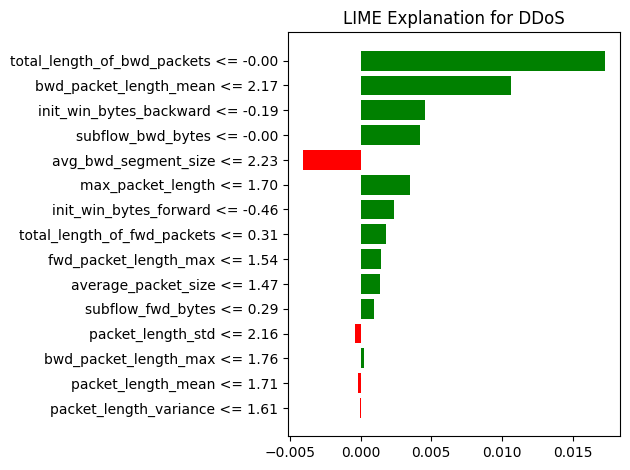

In [83]:
# === Plot LIME ===
fig = explanation.as_pyplot_figure(label=predicted_label)
plt.title(f'LIME Explanation for {predicted_class_name}')
plt.tight_layout()
plt.show()

In [84]:
# === HTML Output with Light Background ===
html_content = explanation.as_html(labels=[predicted_label])

display(HTML(html_content))

In [85]:
# === Summary: Top Contributing Features ===
print("\n🌟 TOP CONTRIBUTING FEATURES")
print("=" * 60)
for i, (feature, importance) in enumerate(sorted(exp_list, key=lambda x: abs(x[1]), reverse=True)[:5], 1):
    status = "SUPPORTS" if importance > 0 else "OPPOSES"
    print(f"{i}. {feature} → {importance:.4f} ({status} prediction)")


🌟 TOP CONTRIBUTING FEATURES
1. total_length_of_bwd_packets <= -0.00 → 0.0173 (SUPPORTS prediction)
2. bwd_packet_length_mean <= 2.17 → 0.0106 (SUPPORTS prediction)
3. init_win_bytes_backward <= -0.19 → 0.0046 (SUPPORTS prediction)
4. subflow_bwd_bytes <= -0.00 → 0.0042 (SUPPORTS prediction)
5. avg_bwd_segment_size <= 2.23 → -0.0041 (OPPOSES prediction)


In [86]:
# === Detailed Feature Impact ===
print("\n🔍 FEATURE VALUE ANALYSIS")
print("=" * 60)
for feat in feature_names:
    value = input_json[feat]
    impact = next((imp for f, imp in exp_list if feat in f), 0)
    print(f"{feat:<35}: {value:>10.2f} | LIME Impact: {impact:>8.4f}")


🔍 FEATURE VALUE ANALYSIS
total_length_of_fwd_packets        :      24.00 | LIME Impact:   0.0018
total_length_of_bwd_packets        :       0.00 | LIME Impact:   0.0173
fwd_packet_length_max              :       6.00 | LIME Impact:   0.0014
bwd_packet_length_max              :       0.00 | LIME Impact:   0.0002
bwd_packet_length_mean             :       0.00 | LIME Impact:   0.0106
max_packet_length                  :       6.00 | LIME Impact:   0.0035
packet_length_mean                 :       6.00 | LIME Impact:   0.0106
packet_length_std                  :       0.00 | LIME Impact:  -0.0004
packet_length_variance             :       0.00 | LIME Impact:  -0.0000
average_packet_size                :       7.50 | LIME Impact:   0.0014
avg_bwd_segment_size               :       0.00 | LIME Impact:  -0.0041
subflow_fwd_bytes                  :      24.00 | LIME Impact:   0.0010
subflow_bwd_bytes                  :       0.00 | LIME Impact:   0.0042
init_win_bytes_forward             :  


📌 SHAP EXPLANATION


PermutationExplainer explainer: 2it [00:11, 11.21s/it]               
PermutationExplainer explainer: 1001it [02:16,  6.98it/s]                          


🔍 SHAP Input Shape: (1, 15, 15)
🔍 SHAP Train Shape: (1000, 15, 15)


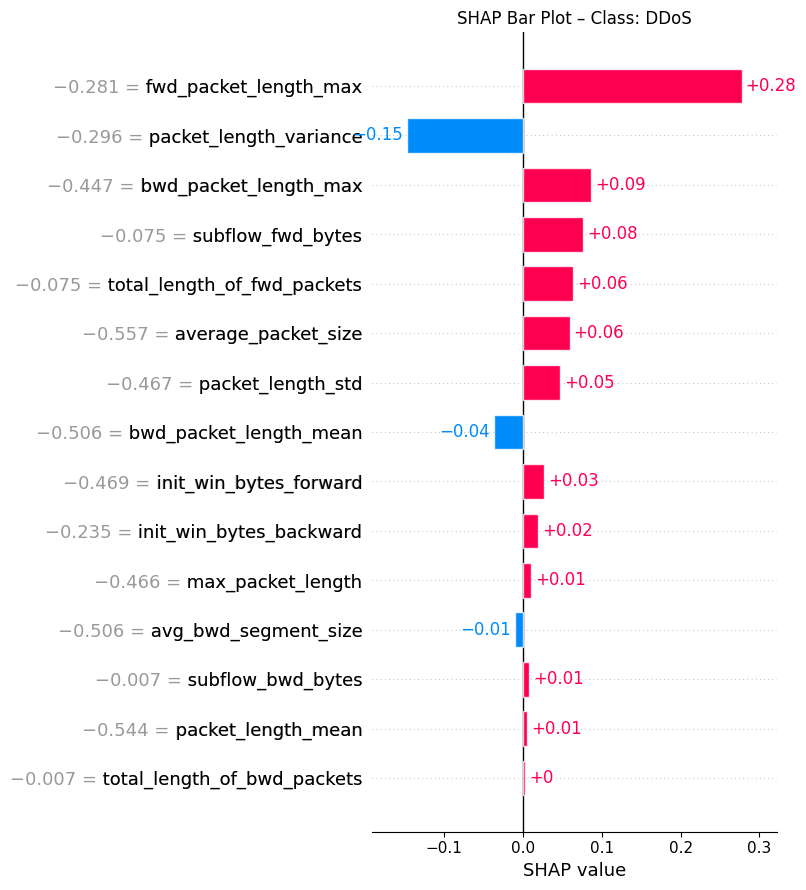

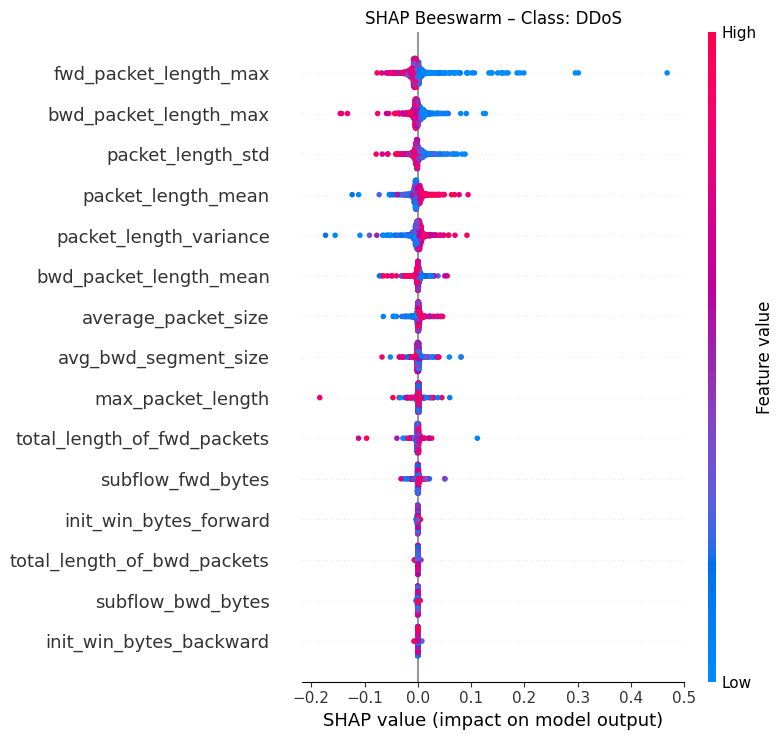

In [87]:
import shap
import matplotlib.pyplot as plt

# === SHAP EXPLANATION ===
print("\n📌 SHAP EXPLANATION")
print("=" * 60)

# Use the correct SHAP explainer for non-tree models
explainer_shap = shap.Explainer(model, training_scaled,output_names=list(le.classes_),feature_names=feature_names)

# Compute SHAP values
shap_values_input = explainer_shap(input_scaled)
shap_values_train = explainer_shap(training_scaled)

print(f"🔍 SHAP Input Shape: {shap_values_input.shape}")
print(f"🔍 SHAP Train Shape: {shap_values_train.shape}")

# === Handle multi-class slicing safely ===
if len(shap_values_input.shape) == 3:
    # Predicted class index might be out of bounds, clamp it
    num_classes = shap_values_input.shape[2]
    safe_class_index = min(predicted_label, num_classes - 1)
    shap_values_input_class = shap_values_input[:, :, safe_class_index]
    shap_values_train_class = shap_values_train[:, :, safe_class_index]
else:
    shap_values_input_class = shap_values_input
    shap_values_train_class = shap_values_train

# === Bar Plot for Input Sample ===
plt.figure(figsize=(10, 5))
shap.plots.bar(shap_values_input_class[0], max_display=15, show=False)
plt.title(f"SHAP Bar Plot – Class: {predicted_class_name}")
plt.tight_layout()
plt.show()

# === Beeswarm Plot for Training Data ===
plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values_train_class, max_display=15, show=False)
plt.title(f"SHAP Beeswarm – Class: {predicted_class_name}")
plt.tight_layout()
plt.show()


In [100]:
# === Step 1: Load model, scaler, and label encoder ===
from tensorflow.keras.models import load_model as load_keras_model

scaler, model, le = load_model("random forest")  # le = LabelEncoder
# scaler, model, le = load_model("svc")
# scaler, model, le = load_model("dnn")

# === Step 2: Load the input JSON data ===
with open(f"{DOCS_DIR}/test.json", "r") as f:
    input_data = json.load(f)

# === Step 3: Function to predict for a single sample ===
def predict_threat(threat_type):
    """Predict threat for a specific sample from the input data"""
    if threat_type not in input_data:
        print(f"❌ Error: '{threat_type}' not found in input data")
        return

    sample_data = input_data[threat_type]
    input_df = pd.DataFrame([sample_data])
    input_scaled = scaler.transform(input_df)

    # Prediction logic based on model type
    if hasattr(model, "predict_proba"):
        y_pred = model.predict(input_scaled)
        y_proba = model.predict_proba(input_scaled)
    else:
        y_pred_raw = model.predict(input_scaled)
        if len(y_pred_raw.shape) == 2 and y_pred_raw.shape[1] > 1:
            y_proba = y_pred_raw
            y_pred = [np.argmax(y_pred_raw[0])]
        else:
            y_pred = [int(y_pred_raw[0])]
            y_proba = np.eye(len(le.classes_))[y_pred[0]].reshape(1, -1)

    predicted_class = y_pred[0]
    threat_label = le.inverse_transform([predicted_class])[0]

    # Output
    print(f"\n=== Prediction for '{threat_type}' ===")
    print("Predicted Class ID:", predicted_class)
    print("Predicted Threat Type:", threat_label)
    print("Actual Threat Type:", threat_type)
    print("Prediction Correct:", threat_label == threat_type)

    print("\nClass Probabilities:")
    for idx, prob in enumerate(y_proba[0]):
        class_name = le.inverse_transform([idx])[0]
        print(f" {idx} - {class_name}: {prob:.4f}")

# === Step 4: Function to predict all samples ===
def predict_all_threats():
    """Predict for all samples in the input data"""
    print("=== Predicting all threat types ===\n")
    for threat_type in input_data.keys():
        predict_threat(threat_type)

# === Step 5: Batch prediction with summary ===
def batch_predict():
    """Convert all samples to DataFrame and predict in batch"""
    samples = []
    labels = []

    for threat_type, features in input_data.items():
        samples.append(features)
        labels.append(threat_type)

    input_df = pd.DataFrame(samples)
    input_scaled = scaler.transform(input_df)

    if hasattr(model, "predict_proba"):
        y_pred = model.predict(input_scaled)
        y_proba = model.predict_proba(input_scaled)
    else:
        y_pred_raw = model.predict(input_scaled)
        if len(y_pred_raw.shape) == 2 and y_pred_raw.shape[1] > 1:
            y_proba = y_pred_raw
            y_pred = np.argmax(y_proba, axis=1)
        else:
            y_pred = y_pred_raw.astype(int)
            y_proba = np.eye(len(le.classes_))[y_pred].reshape(len(y_pred), -1)

    print("\n=== Batch Prediction Results ===")
    for i, (actual, predicted_id) in enumerate(zip(labels, y_pred)):
        predicted_label = le.inverse_transform([predicted_id])[0]
        match = "✓" if actual == predicted_label else "✗"
        print(f"Sample {i+1}: {actual} → Predicted: {predicted_label} (ID: {predicted_id}) - {match}")

        top_probs = [
            f"{le.inverse_transform([j])[0]}: {prob:.3f}"
            for j, prob in enumerate(y_proba[i]) if prob > 0.1
        ]
        print("  Top probabilities:", ", ".join(top_probs))

# === Example Usage ===
if __name__ == "__main__":
    # predict_threat("Web Attack - Sql Injection")
    # predict_all_threats()
    batch_predict()


=== Batch Prediction Results ===
Sample 1: BENIGN → Predicted: BENIGN (ID: 0) - ✓
  Top probabilities: BENIGN: 1.000
Sample 2: Bot → Predicted: Bot (ID: 1) - ✓
  Top probabilities: Bot: 0.901
Sample 3: DDoS → Predicted: DDoS (ID: 2) - ✓
  Top probabilities: DDoS: 0.999
Sample 4: DoS GoldenEye → Predicted: DoS GoldenEye (ID: 3) - ✓
  Top probabilities: DoS GoldenEye: 1.000
Sample 5: DoS Hulk → Predicted: DoS Hulk (ID: 4) - ✓
  Top probabilities: DoS Hulk: 1.000
Sample 6: DoS Slowhttptest → Predicted: DoS Slowhttptest (ID: 5) - ✓
  Top probabilities: DoS Slowhttptest: 1.000
Sample 7: DoS slowloris → Predicted: DoS slowloris (ID: 6) - ✓
  Top probabilities: DoS slowloris: 1.000
Sample 8: FTP-Patator → Predicted: FTP-Patator (ID: 7) - ✓
  Top probabilities: FTP-Patator: 1.000
Sample 9: Heartbleed → Predicted: Heartbleed (ID: 8) - ✓
  Top probabilities: BENIGN: 0.160, Heartbleed: 0.810
Sample 10: Infiltration → Predicted: Infiltration (ID: 9) - ✓
  Top probabilities: BENIGN: 0.150, Infiltr